In [1]:
cd ../src

/Users/phottovy/galvanize/04_Capstone_1/song_lyric_classifier/src


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import itertools
from tabulate import tabulate

In [3]:
from add_stop_words import add_stop_words, nltk_s_words
from main import get_data, set_pipeline, make_predictions, data_test_train_split, combine_stopwords

In [4]:
plt.style.use('seaborn-darkgrid')
plt.rcParams["patch.force_edgecolor"] = True

In [5]:
porter = PorterStemmer()
snowball = SnowballStemmer('english')
wordnet = WordNetLemmatizer()
sksw = ENGLISH_STOP_WORDS
nltksw = nltk_s_words()
addsw = add_stop_words()
allsw = combine_stopwords

In [6]:
def clean_full_dataset(dataset, stopwords=sksw, lemm=None, stem=None):
    clean_dataset = dataset.copy()
    clean_dataset['Lyrics'] = clean_strip_lyrics(
        clean_dataset['Lyrics'], stopwords, lemm, stem)
    clean_lyrics = clean_dataset['Lyrics']
    return clean_dataset, clean_lyrics

In [7]:
def clean_strip_lyrics(dataset, stopwords=sksw, lemm=None, stem=None):
    '''
    Strip punctuation and cleans the word list

    Steps
    -----
    1. remove punctuation
    2. remove stopwords from provided dictionary, default sksw list
        allsw for a combination of three sets of stopwords
    3. stem word list, default None
    4. lemmatize word list, default None
    5. return list of clean word list from lyrics

    Parameters
    ----------
    lyrics: string of lyrics to be cleaned
    stopwords: dictionary of stopwords to exclude from model, default sksw from sklearn
    '''
    rm_punct = [''.join(
        [char for char in word if char not in string.punctuation]) for word in dataset]
    rm_stop = [[word.lower() for word in words.split()if word.lower()
                not in stopwords] for words in rm_punct]
    if lemm == wordnet:
        rm_lemm = [[wordnet.lemmatize(word)
                    for word in words] for words in rm_stop]
    else:
        rm_lemm = rm_stop
    if stem == porter:
        rm_stem = [[porter.stem(word) for word in words] for words in rm_lemm]
    elif stem == snowball:
        rm_stem = [[snowball.stem(word) for word in words]
                   for words in rm_lemm]
    else:
        rm_stem = rm_lemm
    clean_lyrics = [' '.join([word for word in words]) for words in rm_stem]
    return pd.Series(clean_lyrics)

In [8]:
full_dataset = get_data()
clean_dataset, clean_lyrics = clean_full_dataset(
    full_dataset, stopwords=sksw, lemm=None, stem=None)
X_train, X_test, y_train, y_test = data_test_train_split(clean_dataset)
X = clean_dataset['Lyrics']
y = clean_dataset['Test_Artist']

In [9]:
def confusion_matrix_plot_cv(tn, fp, fn, tp, save_fig=False, cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    '''
    cm = np.array([[tp, fn], [fp, tn]])
    classes = ['True', 'False']
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid(b=None)
    plt.title('Confusion Matrix', fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    if save_fig:
        plt.savefig('confusion_matrix.png')
    plt.show()

In [10]:
def my_cross_val_score(dataset, num_folds=3, stopwords=sksw, lemm=None, stem=None, max_feats=None):
    ''' Returns error for k-fold cross validation. '''
    clean_dataset, clean_lyrics = clean_full_dataset(
        dataset, stopwords, lemm, stem)
    X = clean_dataset['Lyrics']
    y = clean_dataset['Test_Artist']

    kf = KFold(n_splits=num_folds, shuffle=True)
    acc_cv = np.empty(num_folds)
    pre_cv = np.empty(num_folds)
    rec_cv = np.empty(num_folds)
    f1_cv = np.empty(num_folds)
    tn, fp, fn, tp = 0, 0, 0, 0
    index = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        lyrics_pipeline = set_pipeline(X_train, y_train, max_feats)
        y_predict = make_predictions(lyrics_pipeline, X_test)
        y_probs = lyrics_pipeline.predict_proba(X_test)[:, 1]
        acc_cv[index] = metrics.accuracy_score(y_test, y_predict)
        pre_cv[index] = metrics.precision_score(y_test, y_predict)
        rec_cv[index] = metrics.recall_score(y_test, y_predict)
        f1_cv[index] = metrics.f1_score(y_test, y_predict)
        tn += metrics.confusion_matrix(y_test, y_predict).ravel()[0]
        fp += metrics.confusion_matrix(y_test, y_predict).ravel()[1]
        fn += metrics.confusion_matrix(y_test, y_predict).ravel()[2]
        tp += metrics.confusion_matrix(y_test, y_predict).ravel()[3]
        index += 1
    cols = ['Statistic', 'Result']
    acc = ['Accuracy', '{:.4f}'.format(np.mean(acc_cv))]
    pre = ['Precision', '{:.4f}'.format(np.mean(pre_cv))]
    rec = ['Recall', '{:.4f}'.format(np.mean(rec_cv))]
    f1 = ['F1-Score', '{:.4f}'.format(np.mean(f1_cv))]
    print('Classification Statistics:\n')
    print(tabulate([cols, acc, pre, rec, f1],
                   headers='firstrow', tablefmt='pipe'))
    print(np.array([[tp, fn], [fp, tn]]))
    confusion_matrix_plot_cv(tn, fp, fn, tp)

In [11]:
def cv_scores(max_splits=10, stopwords=sksw, lemm=None, stem=None, max_feats=None):
    cv_range = range(2, max_splits+1)

    for num in cv_range:
        print(f'# of splits: {num}\n')
        my_cross_val_score(full_dataset, num, stopwords, lemm, stem, max_feats)

# of splits: 2

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.6686 |
| Precision   |   0.6514 |
| Recall      |   0.8554 |
| F1-Score    |   0.7228 |
[[524  93]
 [316 301]]


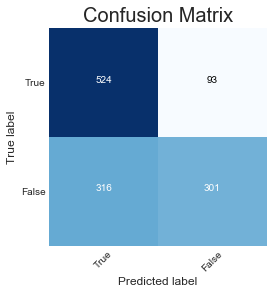

# of splits: 3

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.6912 |
| Precision   |   0.636  |
| Recall      |   0.8961 |
| F1-Score    |   0.7435 |
[[553  64]
 [317 300]]


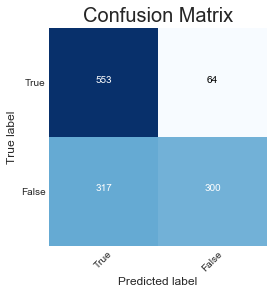

# of splits: 4

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.7034 |
| Precision   |   0.6428 |
| Recall      |   0.9211 |
| F1-Score    |   0.7563 |
[[568  49]
 [317 300]]


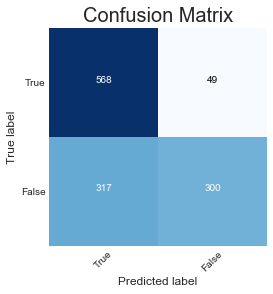

# of splits: 5

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.6969 |
| Precision   |   0.6402 |
| Recall      |   0.9032 |
| F1-Score    |   0.7487 |
[[557  60]
 [314 303]]


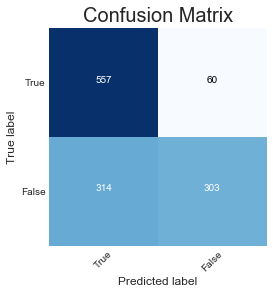

# of splits: 6

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.6921 |
| Precision   |   0.6346 |
| Recall      |   0.9061 |
| F1-Score    |   0.746  |
[[559  58]
 [322 295]]


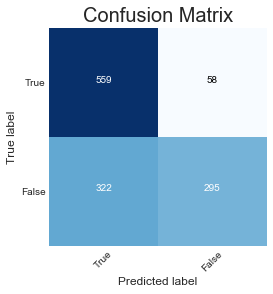

In [12]:
cv_scores(6)

# of splits: 2

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.6977 |
| Precision   |   0.6428 |
| Recall      |   0.8952 |
| F1-Score    |   0.7476 |
[[552  65]
 [308 309]]


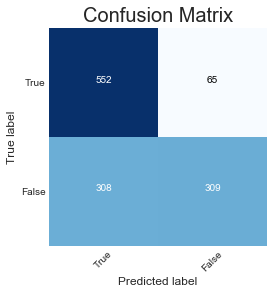

# of splits: 3

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.6978 |
| Precision   |   0.6461 |
| Recall      |   0.8978 |
| F1-Score    |   0.7485 |
[[553  64]
 [309 308]]


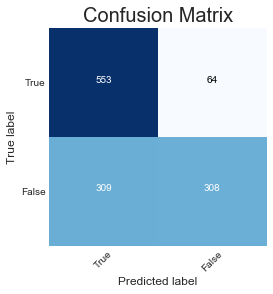

# of splits: 4

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.701  |
| Precision   |   0.647  |
| Recall      |   0.8867 |
| F1-Score    |   0.7477 |
[[547  70]
 [299 318]]


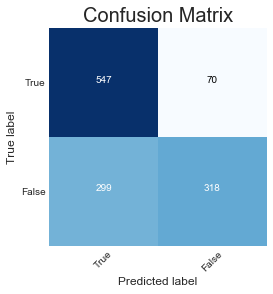

# of splits: 5

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.718  |
| Precision   |   0.6618 |
| Recall      |   0.8947 |
| F1-Score    |   0.7599 |
[[551  66]
 [282 335]]


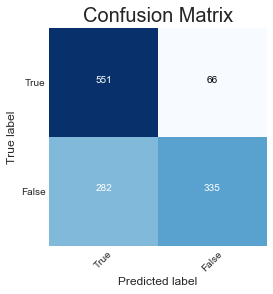

# of splits: 6

Classification Statistics:

| Statistic   |   Result |
|:------------|---------:|
| Accuracy    |   0.7147 |
| Precision   |   0.6613 |
| Recall      |   0.8871 |
| F1-Score    |   0.7561 |
[[547  70]
 [282 335]]


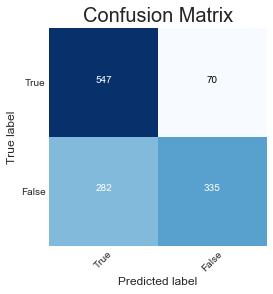

In [13]:
cv_scores(6, stopwords=nltksw, lemm=wordnet, stem=None, max_feats=5000)

In [15]:
def gridsearch_with_output(estimator, parameter_grid, X, y):
    '''
        Parameters: estimator: the type of model (e.g. RandomForestRegressor())
                    paramter_grid: dictionary defining the gridsearch parameters
                    X_train: 2d numpy array
                    y_train: 1d numpy array

        Returns:  best parameters and model fit with those parameters
    '''
    model_gridsearch = GridSearchCV(estimator,
                                    parameter_grid,
                                    n_jobs=-1,
                                    verbose=True,
                                    refit=True,
                                    cv=4,
                                    scoring='f1')  # ['f1', 'precision', 'recall', 'accuracy'])
    model_gridsearch.fit(X, y)
    best_params = model_gridsearch.best_params_
    model_best = model_gridsearch.best_estimator_
    print("\nResult of gridsearch:")
    print("{0:<20s} | {1:<8s} | {2}".format(
        "Parameter", "Optimal", "Gridsearch values"))
    print("-" * 55)
    for param, vals in parameter_grid.items():
        print("{0:<20s} | {1:<8s} | {2}".format(str(param),
                                                str(best_params[param]),
                                                str(vals)))
    return best_params, model_best

In [16]:
def display_default_and_gsearch_model_results(model_default, model_gridsearch,
                                              X_test, y_test):
    '''
        Parameters: model_default: fit model using initial parameters
                    model_gridsearch: fit model using parameters from gridsearch
                    X_test: 2d numpy array
                    y_test: 1d numpy array
        Return: None, but prints out mse and r2 for the default and model with
                gridsearched parameters
    '''
    name = model_default.__class__.__name__.replace(
        'Regressor', '')  # for printing
    y_test_pred = model_gridsearch.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_test_pred)
    pre = metrics.precision_score(y_test, y_test_pred)
    rec = metrics.recall_score(y_test, y_test_pred)
    f1 = metrics.f1_score(y_test, y_test_pred)
#     print("Results for {0}".format(name))
    print("Gridsearched model acc: {:0.3f} | pre: {:0.3f} | rec = {:0.3f} | f1 = {:0.3f}".format(
        acc, pre, rec, f1))
    y_test_pred = model_default.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_test_pred)
    pre = metrics.precision_score(y_test, y_test_pred)
    rec = metrics.recall_score(y_test, y_test_pred)
    f1 = metrics.f1_score(y_test, y_test_pred)
    print("     Default model acc: {:0.3f} | pre: {:0.3f} | rec = {:0.3f} | f1 = {:0.3f}".format(
        acc, pre, rec, f1))

In [17]:
feats_grid = {'convert_lyrics__max_features': [
    None, 50, 100, 500, 1000, 5000, 10000, 12000]}

In [18]:
cv_pipeline = Pipeline([
    ('convert_lyrics', CountVectorizer()),
    ('tf-idf', TfidfTransformer()),
    ('naive_bayes', MultinomialNB())
])

In [19]:
full_nb_grid = {'stopwords': ['sksw', 'nltksw', 'addsw', 'allsw', 'sw_none'],
                'lemm': [None, 'wordnet'],
                'stem': [None, 'snowball', 'porter']}

In [20]:
combs = itertools.product(*(full_nb_grid[Name] for Name in full_nb_grid))


def print_combs(data=combs):
    return ['{}, {}, {}'.format(item[0], item[1], item[2]) for item in data]


combs_list = print_combs()

In [21]:
combs_dict = {'None': None, 'sksw': sksw, 'nltksw': nltksw, 'addsw': addsw, 
              'allsw': allsw(),'sw_none': [], 'wordnet': wordnet, 
              'snowball': snowball, 'porter': porter}

In [22]:
def lyrics_gridsearch(full_dataset, feature_list=combs_list):
    for item in feature_list:
        sw = combs_dict[item.split(', ')[0]]
        lm = combs_dict[item.split(', ')[1]]
        stm = combs_dict[item.split(', ')[2]]

        clean_dataset, clean_lyrics = clean_full_dataset(
            full_dataset, sw, lm, stm)
        X = clean_lyrics
        y = clean_dataset['Test_Artist']

        nb_best_params, nb_best_model = gridsearch_with_output(cv_pipeline,
                                                               feats_grid,
                                                               X, y)
        print("\nComparing model with gridsearch params to initial model on Test set.\n")
        print(
            f"Stopwords: {item.split(', ')[0]}, Lemm: {item.split(', ')[1]}, Stem: {item.split(', ')[2]}\n")
        lyrics_pipeline = set_pipeline(X, y)
        display_default_and_gsearch_model_results(
            lyrics_pipeline, nb_best_model, X, y)
        print('-------------------------------------------------------\n')

In [23]:
lyrics_gridsearch(full_dataset, combs_list)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   18.8s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 12000    | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sksw, Lemm: None, Stem: None

Gridsearched model acc: 0.910 | pre: 0.860 | rec = 0.979 | f1 = 0.916
     Default model acc: 0.910 | pre: 0.858 | rec = 0.982 | f1 = 0.916
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   12.4s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sksw, Lemm: None, Stem: snowball

Gridsearched model acc: 0.823 | pre: 0.786 | rec = 0.888 | f1 = 0.834
     Default model acc: 0.870 | pre: 0.803 | rec = 0.981 | f1 = 0.883
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    9.8s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sksw, Lemm: None, Stem: porter

Gridsearched model acc: 0.825 | pre: 0.785 | rec = 0.895 | f1 = 0.836
     Default model acc: 0.872 | pre: 0.805 | rec = 0.982 | f1 = 0.885
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   11.9s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sksw, Lemm: wordnet, Stem: None

Gridsearched model acc: 0.824 | pre: 0.783 | rec = 0.896 | f1 = 0.836
     Default model acc: 0.886 | pre: 0.824 | rec = 0.981 | f1 = 0.896
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    9.7s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sksw, Lemm: wordnet, Stem: snowball

Gridsearched model acc: 0.824 | pre: 0.789 | rec = 0.885 | f1 = 0.834
     Default model acc: 0.870 | pre: 0.803 | rec = 0.982 | f1 = 0.883
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   14.7s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sksw, Lemm: wordnet, Stem: porter

Gridsearched model acc: 0.826 | pre: 0.788 | rec = 0.891 | f1 = 0.837
     Default model acc: 0.873 | pre: 0.805 | rec = 0.984 | f1 = 0.885
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   10.3s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 1000     | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: nltksw, Lemm: None, Stem: None

Gridsearched model acc: 0.839 | pre: 0.806 | rec = 0.891 | f1 = 0.847
     Default model acc: 0.897 | pre: 0.837 | rec = 0.987 | f1 = 0.906
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   12.4s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: nltksw, Lemm: None, Stem: snowball

Gridsearched model acc: 0.814 | pre: 0.771 | rec = 0.891 | f1 = 0.827
     Default model acc: 0.861 | pre: 0.789 | rec = 0.985 | f1 = 0.876
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    9.5s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 5000     | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: nltksw, Lemm: None, Stem: porter

Gridsearched model acc: 0.891 | pre: 0.840 | rec = 0.964 | f1 = 0.898
     Default model acc: 0.860 | pre: 0.788 | rec = 0.984 | f1 = 0.875
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   10.4s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 5000     | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: nltksw, Lemm: wordnet, Stem: None

Gridsearched model acc: 0.904 | pre: 0.857 | rec = 0.969 | f1 = 0.910
     Default model acc: 0.877 | pre: 0.810 | rec = 0.985 | f1 = 0.889
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   12.0s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: nltksw, Lemm: wordnet, Stem: snowball

Gridsearched model acc: 0.817 | pre: 0.776 | rec = 0.891 | f1 = 0.830
     Default model acc: 0.861 | pre: 0.790 | rec = 0.984 | f1 = 0.877
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   12.7s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: nltksw, Lemm: wordnet, Stem: porter

Gridsearched model acc: 0.813 | pre: 0.773 | rec = 0.887 | f1 = 0.826
     Default model acc: 0.862 | pre: 0.791 | rec = 0.984 | f1 = 0.877
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   16.8s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 1000     | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: addsw, Lemm: None, Stem: None

Gridsearched model acc: 0.835 | pre: 0.782 | rec = 0.927 | f1 = 0.849
     Default model acc: 0.823 | pre: 0.740 | rec = 0.994 | f1 = 0.848
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   19.4s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: addsw, Lemm: None, Stem: snowball

Gridsearched model acc: 0.801 | pre: 0.753 | rec = 0.896 | f1 = 0.819
     Default model acc: 0.798 | pre: 0.715 | rec = 0.992 | f1 = 0.831
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.0s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: addsw, Lemm: None, Stem: porter

Gridsearched model acc: 0.804 | pre: 0.755 | rec = 0.900 | f1 = 0.821
     Default model acc: 0.803 | pre: 0.720 | rec = 0.992 | f1 = 0.834
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.1s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 1000     | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: addsw, Lemm: wordnet, Stem: None

Gridsearched model acc: 0.831 | pre: 0.782 | rec = 0.917 | f1 = 0.844
     Default model acc: 0.807 | pre: 0.724 | rec = 0.994 | f1 = 0.837
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.2s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: addsw, Lemm: wordnet, Stem: snowball

Gridsearched model acc: 0.806 | pre: 0.758 | rec = 0.898 | f1 = 0.822
     Default model acc: 0.805 | pre: 0.722 | rec = 0.992 | f1 = 0.835
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.8s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: addsw, Lemm: wordnet, Stem: porter

Gridsearched model acc: 0.808 | pre: 0.761 | rec = 0.898 | f1 = 0.824
     Default model acc: 0.807 | pre: 0.724 | rec = 0.992 | f1 = 0.837
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    8.6s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: allsw, Lemm: None, Stem: None

Gridsearched model acc: 0.818 | pre: 0.780 | rec = 0.887 | f1 = 0.830
     Default model acc: 0.915 | pre: 0.866 | rec = 0.982 | f1 = 0.920
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   11.8s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: allsw, Lemm: None, Stem: snowball

Gridsearched model acc: 0.812 | pre: 0.771 | rec = 0.888 | f1 = 0.825
     Default model acc: 0.880 | pre: 0.818 | rec = 0.977 | f1 = 0.891
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   10.2s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: allsw, Lemm: None, Stem: porter

Gridsearched model acc: 0.810 | pre: 0.767 | rec = 0.890 | f1 = 0.824
     Default model acc: 0.880 | pre: 0.818 | rec = 0.977 | f1 = 0.891
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    9.8s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: allsw, Lemm: wordnet, Stem: None

Gridsearched model acc: 0.821 | pre: 0.778 | rec = 0.898 | f1 = 0.834
     Default model acc: 0.895 | pre: 0.836 | rec = 0.984 | f1 = 0.904
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    9.4s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: allsw, Lemm: wordnet, Stem: snowball

Gridsearched model acc: 0.814 | pre: 0.774 | rec = 0.887 | f1 = 0.826
     Default model acc: 0.881 | pre: 0.819 | rec = 0.977 | f1 = 0.891
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:    8.7s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 5000     | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: allsw, Lemm: wordnet, Stem: porter

Gridsearched model acc: 0.897 | pre: 0.853 | rec = 0.959 | f1 = 0.903
     Default model acc: 0.880 | pre: 0.818 | rec = 0.977 | f1 = 0.891
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   19.4s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 1000     | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sw_none, Lemm: None, Stem: None

Gridsearched model acc: 0.823 | pre: 0.775 | rec = 0.911 | f1 = 0.838
     Default model acc: 0.814 | pre: 0.731 | rec = 0.994 | f1 = 0.842
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   15.4s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sw_none, Lemm: None, Stem: snowball

Gridsearched model acc: 0.805 | pre: 0.763 | rec = 0.885 | f1 = 0.819
     Default model acc: 0.794 | pre: 0.711 | rec = 0.992 | f1 = 0.828
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   23.1s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 1000     | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sw_none, Lemm: None, Stem: porter

Gridsearched model acc: 0.828 | pre: 0.784 | rec = 0.906 | f1 = 0.841
     Default model acc: 0.796 | pre: 0.712 | rec = 0.992 | f1 = 0.829
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   18.4s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 1000     | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sw_none, Lemm: wordnet, Stem: None

Gridsearched model acc: 0.826 | pre: 0.779 | rec = 0.909 | f1 = 0.839
     Default model acc: 0.803 | pre: 0.720 | rec = 0.992 | f1 = 0.834
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   18.4s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 500      | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sw_none, Lemm: wordnet, Stem: snowball

Gridsearched model acc: 0.807 | pre: 0.764 | rec = 0.888 | f1 = 0.822
     Default model acc: 0.798 | pre: 0.715 | rec = 0.992 | f1 = 0.831
-------------------------------------------------------

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   19.2s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
convert_lyrics__max_features | 1000     | [None, 50, 100, 500, 1000, 5000, 10000, 12000]

Comparing model with gridsearch params to initial model on Test set.

Stopwords: sw_none, Lemm: wordnet, Stem: porter

Gridsearched model acc: 0.830 | pre: 0.785 | rec = 0.908 | f1 = 0.842
     Default model acc: 0.799 | pre: 0.716 | rec = 0.992 | f1 = 0.832
-------------------------------------------------------

